In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
import time as toc
%matplotlib inline

In [2]:
def K(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

In [3]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = K(xx,sigma_dict['C'])
    KH = K(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(1,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))*dt
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])*dt
        output[i+1,:] = (output[i,:]+dyj)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

In [4]:
def STA(r, x, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA

def STA_centered(r, x, dt, window):
    x = x - np.mean(x)
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA

In [5]:
def Ay(para_dict, sigma_dict, x, n = 1000):
    alpha = para_dict['alpha']
    beta = para_dict['beta']
    k = para_dict['k']
    phi = para_dict['phi']
    g = para_dict['g']
    sigma_h = sigma_dict['H']
    sigma_c = sigma_dict['C']
    ans =  0
    for i in range(n+1):
        ans += k/alpha/np.sqrt(np.pi)*(-k*g/alpha/beta)**i/np.sqrt(sigma_c**2+i*sigma_h**2)*np.exp(-x**2/(sigma_c**2+i*sigma_h**2))
    return ans

In [6]:
sigma_dict = dict()
sigma_dict['H'] = 1
sigma_dict['C'] = sigma_dict['H']*2/3# RF size of cone cell
dx = 0.05*sigma_dict['H']
 
dt=0.01
sigma_dict['tau_y'] = 0.02

In [7]:
#Width setting
xlen = 2000*dx #spatial extend of simulation
hw = 0.75*sigma_dict['H']#half bar width
tempx = np.arange(0,xlen,dx)

In [8]:
para_dict = {}
para_dict['alpha'] = 80
para_dict['beta'] = 2
para_dict['k'] = 100
para_dict['phi'] = 1.0
para_dict['g'] = 1.5

para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta']

0.9375

Text(0.5, 1.0, 'Show Analitc Solution of Steady State')

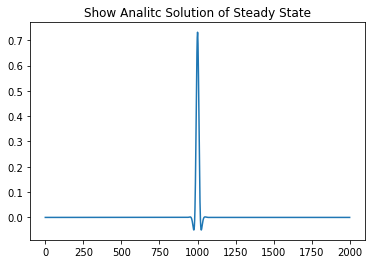

In [9]:
x = np.arange(-int(xlen/dx/2),int(xlen/dx/2))*dx
plt.plot(Ay(para_dict,sigma_dict,x))
plt.title('Show Analitc Solution of Steady State')

## Whole Field STA

In [10]:
homo_cSTA = np.matmul((np.random.randn(5000)*0.3+1)[:, np.newaxis], np.ones(int(xlen/dx))[np.newaxis, :])
y, zts, _ = Retina_Mechine_1D(homo_cSTA, sigma_dict, para_dict, dx, dt)

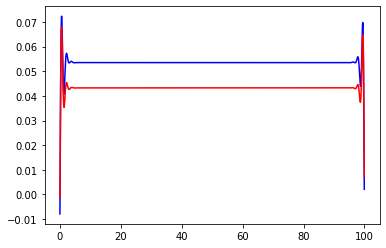

In [11]:
#####PLot numerical solution########
plt.plot(tempx,y.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution

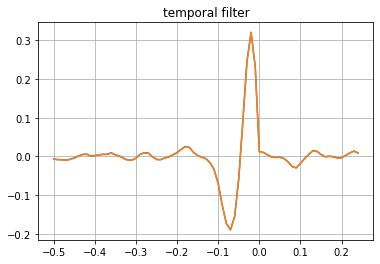

In [12]:
output = y[:,int(xlen/dx/2)]
time, xSTA = STA(output, homo_cSTA[:,0], dt, [-0.5,0.25])
time, xSTA2 = STA_centered(output, homo_cSTA[:,0], dt, [-0.5,0.25])
plt.plot(time, xSTA-1)
plt.plot(time, xSTA2)
plt.title('temporal filter')
plt.grid()

## A Smooth Constant speed Moving Bar

In [13]:
nstep = 1600
moving_bar = np.zeros([nstep, int(xlen/dx)])
pos = 0
v = 0.5 #dx/step
hw = 10 #dx
pos = 600
speak = np.zeros(nstep)
for i in range(nstep):
    pos = pos+v
    moving_bar[i,max(int(pos-hw), 0):min(int(pos+hw), int(xlen/dx))] = 1
    speak[i] = pos*dt

In [14]:
SbS_y, zts, rpeak = Retina_Mechine_1D(moving_bar, sigma_dict, para_dict, dx, dt)

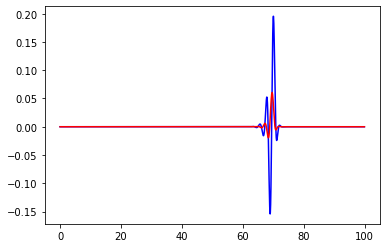

In [15]:
#####PLot numerical solution########
plt.plot(tempx,SbS_y.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution

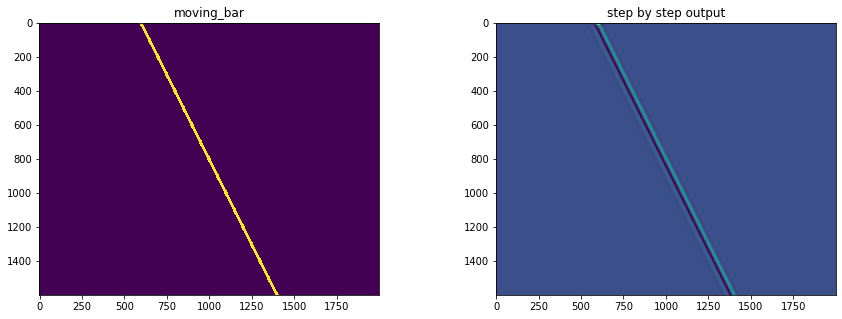

In [16]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.imshow(moving_bar)
ax2.set_title('moving_bar')
ax3.imshow(SbS_y)
ax3.set_title('step by step output')
fig.set_size_inches(15, 5)

Text(0.5, 1.0, 'prediction')

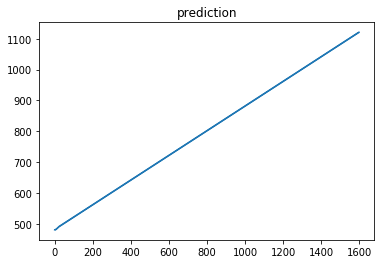

In [17]:
plt.plot(((rpeak-speak)/dx)[1:])
# plt.xlim([100,nstep])
# plt.ylim([-hw,+hw])
plt.title('prediction')

## spatial-temporal Checker 

In [18]:
nstep = 10000
ST_cSTA = np.random.randn(nstep, int(xlen/dx))*0.3+1
y, zts, _ = Retina_Mechine_1D(ST_cSTA, sigma_dict, para_dict, dx, dt)

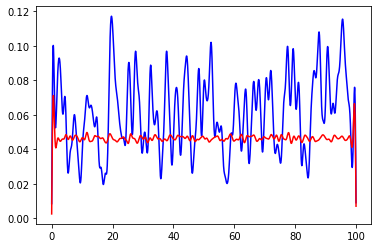

In [19]:
#####PLot numerical solution########
plt.plot(tempx,y.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution

In [20]:
tic = toc.time()
time_window = [-0.4,0.1]
space_window = [700,1300]
nstep = int(np.diff(time_window)/dt)
test2 = np.zeros([nstep, int(xlen/dx)])
test3 = np.zeros([nstep, int(xlen/dx)])
test4 = np.zeros([nstep, int(xlen/dx)])
denominator = np.zeros(int(xlen/dx))
denominator2 = np.zeros(int(xlen/dx))
step = np.round(np.arange(time_window[0],time_window[1],dt)/dt).astype(int)
ST_cSTA_c = ST_cSTA - np.mean(ST_cSTA)
for i in range(nstep):
    for ii in np.arange(max(-step[i],0), y.shape[0]-1+min(-step[i], 0)):
        test2[i,:] += np.correlate(y[ii,:],ST_cSTA_c[step[i]+ii, :], 'same')
        denominator += np.correlate(y[ii,:],np.ones_like(ST_cSTA[0, :]), 'same')
        denominator2 += np.correlate(np.ones_like(y[ii,:]),np.ones_like(ST_cSTA[0, :]), 'same')
    test3[i,:] = np.divide(test2[i,:],denominator,  where = denominator!=0)
    test4[i,:] = np.divide(test2[i,:],denominator2,  where = denominator2!=0)
#         test2[i,:] += y[ii,int(xlen/dx/2)]*ST_cSTA[step[i]+ii, :]*dt*dx
toc.time()-tic

485.84113693237305

In [21]:
output = y[:,int(xlen/dx/2)]
time, xSTA = STA(output, ST_cSTA[:,0], dt, [-0.4,0.1])
test = xSTA[:, np.newaxis]
for j in range(1, int(xlen/dx)):
    _, xSTA = STA(output, ST_cSTA[:,j], dt, [-0.4,0.1])
    test = np.concatenate((test, xSTA[:, np.newaxis]), axis=1)

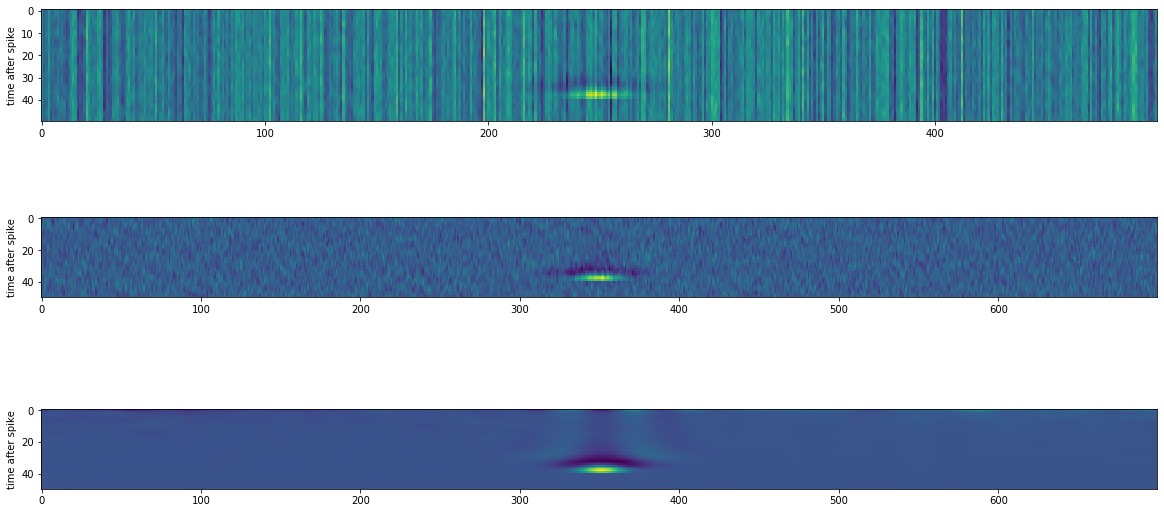

In [22]:
test1 = test-(np.mean(ST_cSTA, axis = 0)[np.newaxis,:])
fig, (ax2, ax3, ax4) = plt.subplots(nrows=3, ncols=1)
ax2.imshow(test[:,750:1250])
ax2.set_ylabel('time after spike')
# ax2.set_yticks(np.arange(5,50,10))
# ax.set_yticklabels(['-0.2','-0.1','0','1','2'])
# ax.set_xticks(np.arange(300,701,100))
# ax.set_xticklabels(['-200','-100','0','100','200'])
# ax.set_xlabel('distance from the cell')
# ax.set_xlim([300, 701])
ax3.imshow(test1[:,650:1350])
ax3.set_ylabel('time after spike')
ax4.imshow((test3)[:,650:1350])
ax4.set_ylabel('time after spike')
fig.set_size_inches(20, 10)

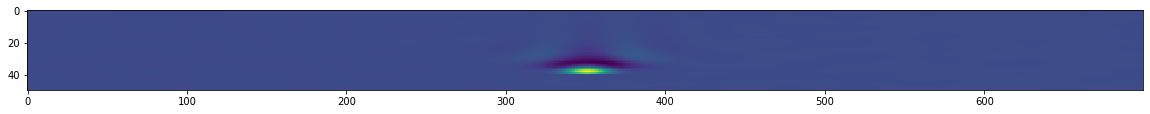

In [23]:
# plt.imshow((test2-(np.mean(test2, axis = 0)[np.newaxis,:]))[:,650:1350])
denominator = (np.append(np.arange(int(xlen/dx/2),int(xlen/dx)), np.arange(int(xlen/dx)-1,int(xlen/dx/2)-1,-1)))
plt.imshow((test2)[:,650:1350])
fig = plt.gcf()
fig.set_size_inches(20, 5)

(-1, 77001, 77001)

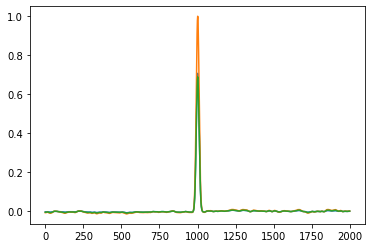

In [24]:
index = 39
plt.plot(np.squeeze(test2[index,:])/np.max(test2))
plt.plot(np.squeeze(test3[index,:])/np.max(test3[index,:]))
plt.plot(np.squeeze(test4[index,:])/np.max(test4))
step[index], np.argmax(test2), np.argmax(test3)

choose center cell and a certain time before spike

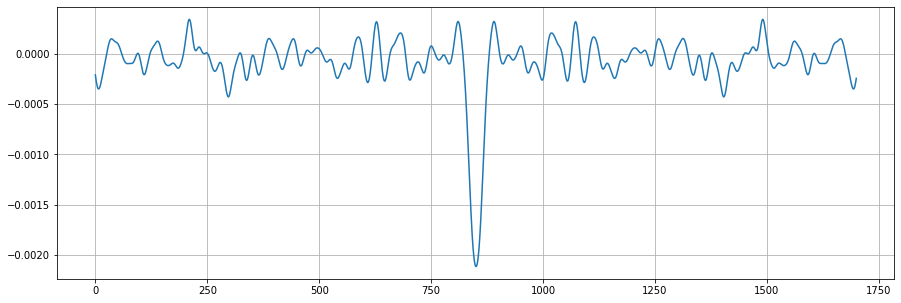

In [25]:
tbs_i = 30
xx = np.arange(-dx*150,dx*150,dx)
KKK = K(xx, dx*10)
plt.plot(np.convolve((test1[tbs_i, :]+np.flip(test1[tbs_i, :]))/2,KKK,'valid')*dx)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15, 5)

In [26]:
ST_kernel = []
for i in np.arange(0,np.argmin(np.abs(time))):
    ST_kernel.append(np.convolve((test1[i, :]+np.flip(test1[i, :]))/2,KKK,'valid')*dx)
ST_kernel = np.flipud(np.array(ST_kernel))

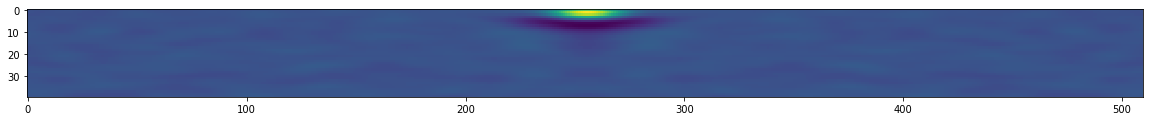

In [27]:
plt.imshow(ST_kernel[:,int(ST_kernel.shape[1]*0.35):int(ST_kernel.shape[1]*0.65)])
# plt.imshow(ST_kernel)
fig = plt.gcf()
fig.set_size_inches(20, 5)

## Simply apply spatial-temporal kernel on moving bar

In [28]:
tic = toc.time()
nstep = 1600
mb_y = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in np.arange(max(i-np.shape(ST_kernel)[0]+1, 0), i+1):
        mb_y[i,:] += np.convolve(moving_bar[ii,:],ST_kernel[i-ii, :], 'same')
toc.time()-tic

17.9928777217865

In [29]:
#1d scipy.signal.convolve much slower than numpy.convolve (https://github.com/scipy/scipy/issues/5280)
# STK = np.concatenate((np.zeros_like(ST_kernel),ST_kernel), axis = 0)
# np.shape(STK)
# tic = toc.time()
# nstep = 1600
# con2d_y = signal.convolve2d(moving_bar.T, STK.T,  mode='same')
# print(toc.time()-tic)
# plt.imshow(con2d_y.T)

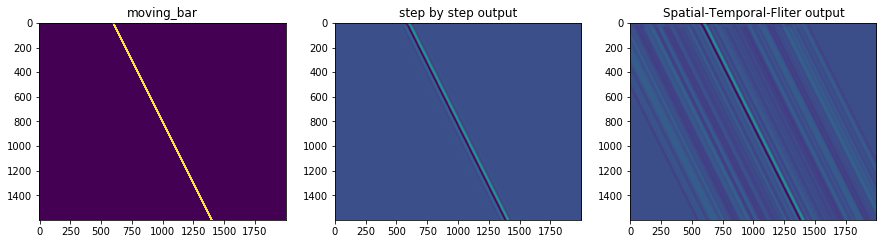

In [30]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3) 
ax2.imshow(moving_bar)
ax2.set_title('moving_bar')
ax3.imshow(SbS_y)
ax3.set_title('step by step output')
ax4.imshow(mb_y)
ax4.set_title('Spatial-Temporal-Fliter output')
fig.set_size_inches(15, 5)

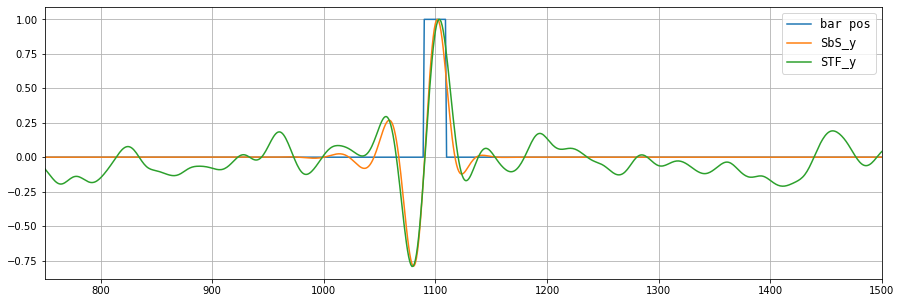

In [31]:
plt.plot(moving_bar[1000,:])
plt.plot(SbS_y[1000,:]/max(SbS_y[1000,:]))
plt.plot(mb_y[1000,:]/max(mb_y[1000,:]))
# plt.plot(con2d_y[1000,:]/max(con2d_y[1000,:]))
plt.grid()
fig = plt.gcf()
plt.legend( ('bar pos', 'SbS_y', 'STF_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.xlim([750,1500])
fig.set_size_inches(15, 5)

## Apply SVD on Spatial-Temporal Kernel

In [32]:
from numpy import linalg as la
U,sigma,VT=la.svd(ST_kernel)

In [33]:
sigma/sum(sigma)

array([0.33581228, 0.11388955, 0.06013742, 0.05610259, 0.05163781,
       0.04561937, 0.04228798, 0.03933143, 0.02873447, 0.02659666,
       0.02502111, 0.02275999, 0.01938811, 0.01556728, 0.01241688,
       0.01143723, 0.00986846, 0.009022  , 0.00720096, 0.00683035,
       0.00620749, 0.00581051, 0.0053589 , 0.00420713, 0.0041302 ,
       0.00394503, 0.00384092, 0.0033189 , 0.00313779, 0.00279184,
       0.00274779, 0.00238382, 0.00212212, 0.00186323, 0.0016608 ,
       0.00164785, 0.00156882, 0.0014277 , 0.00120314, 0.0009641 ])

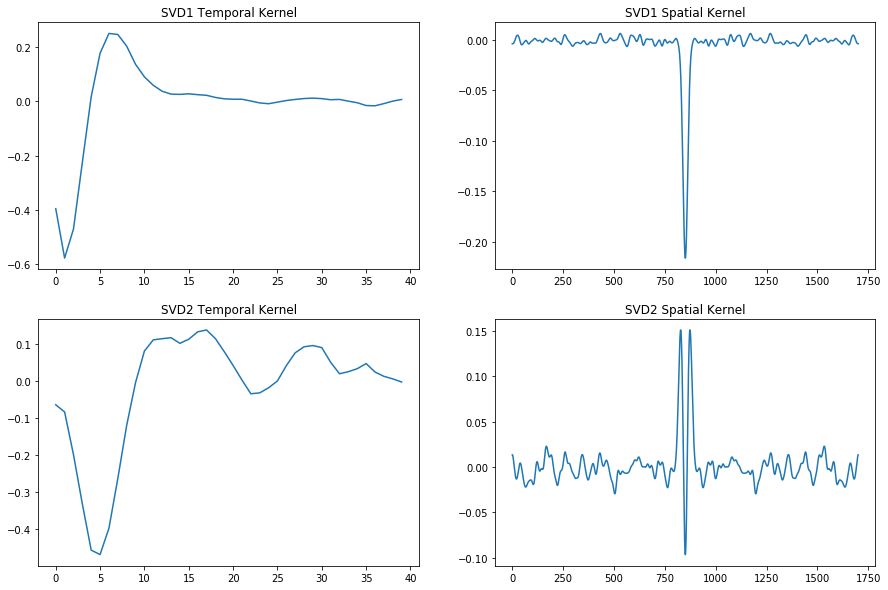

In [34]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

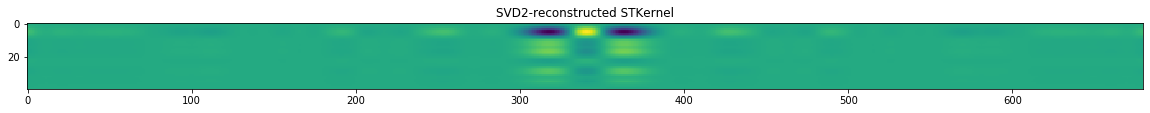

In [35]:
cSVD = 1
SVD_STkernel = np.matmul(U[:,cSVD][:, np.newaxis], VT[cSVD,:][np.newaxis, :])
plt.imshow(SVD_STkernel[:,int(ST_kernel.shape[1]*0.3):int(ST_kernel.shape[1]*0.7)])
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
fig = plt.gcf()
fig.set_size_inches(20, 5)

In [36]:
nstep = 1600
SVD_STK_y = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in range(i):
        if (i-ii) < np.shape(ST_kernel)[0]:
            SVD_STK_y[i,:] += np.convolve(moving_bar[ii,:],SVD_STkernel[i-ii, :], 'same')

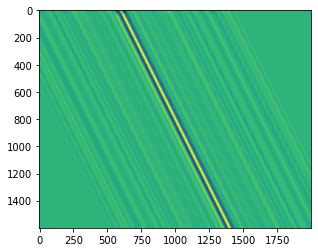

In [37]:
plt.imshow(SVD_STK_y)

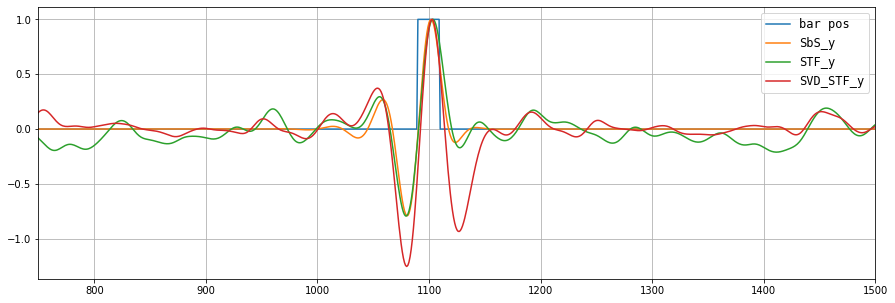

In [38]:
plt.plot(moving_bar[1000,:])
plt.plot(SbS_y[1000,:]/max(SbS_y[1000,:]))
plt.plot(mb_y[1000,:]/max(mb_y[1000,:]))
plt.plot(SVD_STK_y[1000,:]/max(SVD_STK_y[1000,:]))
plt.grid()
fig = plt.gcf()
plt.legend( ('bar pos', 'SbS_y', 'STF_y', 'SVD_STF_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.xlim([750,1500])
fig.set_size_inches(15, 5)

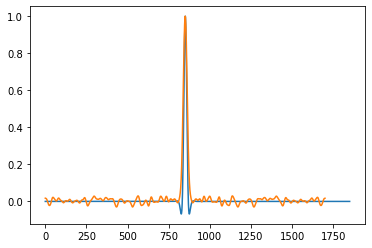

In [39]:
A_y = Ay(para_dict,sigma_dict,x)
plt.plot(A_y[149:]/max(A_y))
plt.plot(VT[0,:]/min(VT[0,:]))

In [40]:
A_y = Ay(para_dict,sigma_dict,x)
len(VT[0,:] )

1701

In [41]:
np.argmax(A_y[149:])

851

In [42]:
A_y[999], A_y[1000], A_y[1001]

(0.7263249168468656, 0.7315721707672499, 0.7263249168468656)

In [43]:
nstep = 1600
moving_bar2 = np.zeros([nstep, int(xlen/dx)])
v = 0.8#dx/step
hw = 30 #dx
pos = 1800
speak = np.zeros(nstep)
for i in range(nstep):
    pos = pos-v
    moving_bar2[i,max(int(pos-hw), 0):min(int(pos+hw), int(xlen/dx))] = 1
#     speak[i] = pos*dt

In [44]:
SbS_y2, zts, rpeak = Retina_Mechine_1D(moving_bar2, sigma_dict, para_dict, dx, dt)

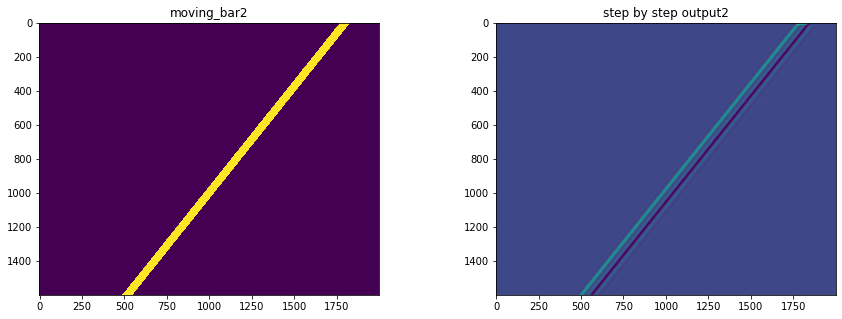

In [45]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
ax2.imshow(moving_bar2)
ax2.set_title('moving_bar2')
ax3.imshow(SbS_y2)
ax3.set_title('step by step output2')
fig.set_size_inches(15, 5)

In [46]:
SbS_y3, zts, rpeak = Retina_Mechine_1D(moving_bar2+moving_bar, sigma_dict, para_dict, dx, dt)

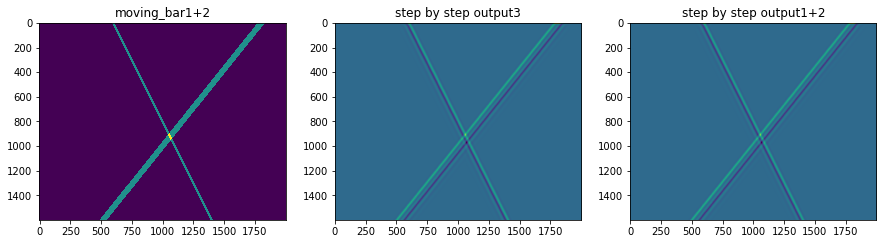

In [47]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3) 
ax2.imshow(moving_bar2+moving_bar)
ax2.set_title('moving_bar1+2')
ax3.imshow(SbS_y3)
ax3.set_title('step by step output3')
ax4.imshow(SbS_y+SbS_y2)
ax4.set_title('step by step output1+2')
fig.set_size_inches(15, 5)

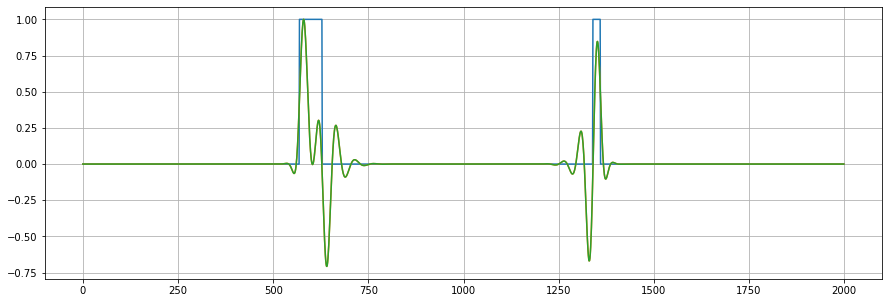

In [48]:
plt.plot((moving_bar2+moving_bar)[1500,:])
plt.plot(SbS_y3[1500,:]/max(SbS_y3[1500,:]))
plt.plot((SbS_y+SbS_y2)[1500,:]/max((SbS_y+SbS_y2)[1500,:]))
plt.grid()
fig = plt.gcf()
# plt.legend( ('bar pos', 'SbS_y', 'STF_y', 'SVD_STF_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.xlim([750,1500])
fig.set_size_inches(15, 5)

In [49]:
SbS_y3 == SbS_y+SbS_y2

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [50]:
tic = toc.time()
nstep = 1600
mb_y2 = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in np.arange(max(i-np.shape(ST_kernel)[0]+1, 0), i+1):
        mb_y2[i,:] += np.convolve(moving_bar2[ii,:],ST_kernel[i-ii, :], 'same')
toc.time()-tic

17.734567642211914

In [51]:
tic = toc.time()
nstep = 1600
mb_y3 = np.zeros([nstep, int(xlen/dx)])
for i in range(nstep):
    for ii in np.arange(max(i-np.shape(ST_kernel)[0]+1, 0), i+1):
        mb_y3[i,:] += np.convolve(moving_bar2[ii,:]+moving_bar[ii,:],ST_kernel[i-ii, :], 'same')
toc.time()-tic

18.397794723510742

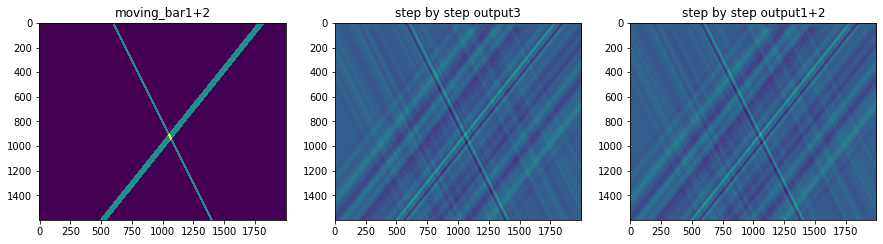

In [52]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3) 
ax2.imshow(moving_bar2+moving_bar)
ax2.set_title('moving_bar1+2')
ax3.imshow(mb_y3)
ax3.set_title('step by step output3')
ax4.imshow(mb_y+mb_y2)
ax4.set_title('step by step output1+2')
fig.set_size_inches(15, 5)

In [53]:
(mb_y3 == mb_y+mb_y2).all()

False